In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.ndimage.filters import uniform_filter

In [2]:
%matplotlib inline

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf
import prepare_sat_data as prep

In [4]:
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')
domain_shape = np.load('./data/domain_shape.npy')
lats = np.load('./data/lats.npy')
lons = np.load('./data/lons.npy')
x = np.load('./data/x.npy')
y = np.load('./data/y.npy')
cloudiness_index = pd.read_hdf('./data/cloudiness_index.h5')
clearsky = pd.read_hdf('./data/clearsky.h5')
pixel = pd.read_hdf('./data/pixel.h5')

In [6]:
U = pd.read_hdf('./data/winds/U_15.h5')
V = pd.read_hdf('./data/winds/V_15.h5')
wind_lats = np.load('./data/winds/wind_lats.npy')
wind_lons = np.load('./data/winds/wind_lons.npy')

In [7]:
U_shape = np.load('./data/winds/U_shape.npy')
V_shape = np.load('./data/winds/V_shape.npy')
wind_times = pd.read_hdf('./data/winds/times.h5').index

In [77]:

cloudiness_15 = cloudiness_index.ix['2014-04-15']
cloudiness_14 = cloudiness_index.ix['2014-04-14']
cloudiness_14.index = cloudiness_14.index + pd.Timedelta('1day')

cc_15 = (cloudiness_15 - cloudiness_14).clip(lower=0)

clearsky_15 = clearsky.ix['2014-04-15']
cloudiness_14 = cloudiness_index.ix['2014-04-14']
clearsky_14 = clearsky.ix['2014-04-14']

ktm_15 = (2.36*cloudiness_15**5 - 6.2*cloudiness_15**4 +
       6.22*cloudiness_15**3 - 2.63*cloudiness_15**2 -
       0.58*cloudiness_15 + 1)

ktm_15_cc = (2.36*cc_15**5 - 6.2*cc_15**4 +
             6.22*cc_15**3 - 2.63*cc_15**2 -
             0.58*cc_15 + 1)
# GHI_15 = ktm*clearsky_15*(0.0001*ktm*clearsky_15 + 0.9)
GHI_15 = ktm_15*(0.0001*ktm_15 + 0.9)

ktm_14 = (2.36*cloudiness_14**5 - 6.2*cloudiness_14**4 +
       6.22*cloudiness_14**3 - 2.63*cloudiness_14**2 -
       0.58*cloudiness_14 + 1)
# GHI_14 = ktm*clearsky_14*(0.0001*ktm*clearsky_14 + 0.9)
GHI_14 = ktm_14*(0.0001*ktm_14 + 0.9)
GHI_14.index = GHI_14.index + pd.Timedelta('1day')
ktm_14.index = ktm_14.index + pd.Timedelta('1day')
cloudiness_14.index = cloudiness_14.index + pd.Timedelta('1day')
# csi_15 = GHI_15/GHI_14
csi_15 = ktm_15/ktm_14

(50.0, 450.0, -150.0, 250.0)

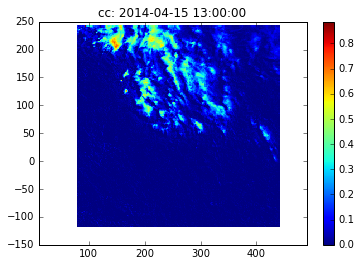

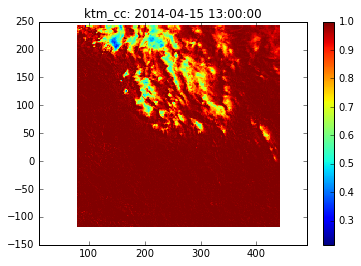

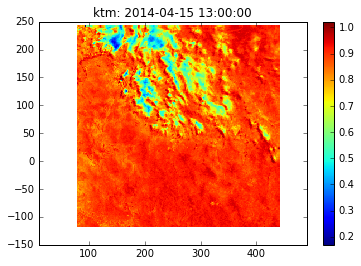

In [75]:
# date_range = pd.date_range('2014-04-15')
this_time = '2014-04-15 13:00:00'
cmap='jet'

# vmin=0
# vmax=1.2
cloudiness_1415 = cloudiness_14.copy()
cloudiness_1415.index = cloudiness_14.index + pd.Timedelta('1day')

cloudiness_norm = cloudiness_15/cloudiness_1415

plt.figure()
im = plt.pcolormesh(x.reshape(domain_shape), y.reshape(domain_shape),
    (cc_15).ix[this_time].values.reshape(domain_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('cc: ' + str(this_time))
plt.axis('equal')

plt.figure()
im = plt.pcolormesh(x.reshape(domain_shape), y.reshape(domain_shape),
    (ktm_15_cc).ix[this_time].values.reshape(domain_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('ktm_cc: ' + str(this_time))
plt.axis('equal')

plt.figure()
im = plt.pcolormesh(x.reshape(domain_shape), y.reshape(domain_shape),
    (ktm_15).ix[this_time].values.reshape(domain_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('ktm: ' + str(this_time))
plt.axis('equal')

In [76]:
dx = .25
dy = .25
x_fine = np.arange(x[0], x[-1] + dx, dx)
y_fine = np.arange(y[0], y[-1] + dy, dy)
x_fine, y_fine = np.meshgrid(x_fine, y_fine)
fine_shape = x_fine.shape
x_fine = x_fine.ravel()
y_fine = y_fine.ravel()
interp_positions = np.stack([x_fine, y_fine], axis=1)
sat_times = csi_15.index

In [78]:
data = cloudiness_15.values.T
data_positions = np.stack([x, y], axis=1)
f = interpolate.NearestNDInterpolator(data_positions, data)
data = f(interp_positions).T
data = data.reshape(
    [sat_times.size, fine_shape[0], fine_shape[1]])
data = uniform_filter(
    data, size=(0, 4, 4)).reshape(
    [sat_times.size, fine_shape[0]*fine_shape[1]])
cloudiness_15 = pd.DataFrame(data=data, index=sat_times)

In [81]:
data = cloudiness_14.values.T
data_positions = np.stack([x, y], axis=1)
f = interpolate.NearestNDInterpolator(data_positions, data)
data = f(interp_positions).T
data = data.reshape(
    [sat_times.size, fine_shape[0], fine_shape[1]])
data = uniform_filter(
    data, size=(0, 4, 4)).reshape(
    [sat_times.size, fine_shape[0]*fine_shape[1]])
cloudiness_14 = pd.DataFrame(data=data, index=sat_times)

(50.0, 450.0, -150.0, 250.0)

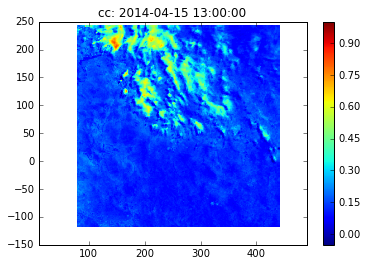

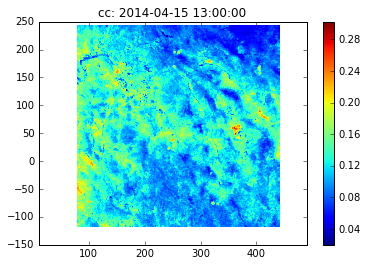

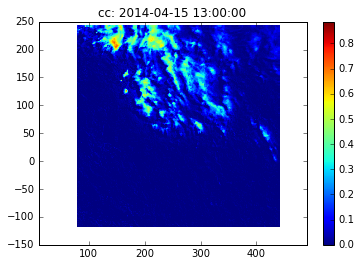

In [84]:
this_time = '2014-04-15 13:00:00'
cmap='jet'

# vmin=0
# vmax=1.2

plt.figure()
im = plt.pcolormesh(x_fine.reshape(fine_shape), y_fine.reshape(fine_shape),
    (cloudiness_15).ix[this_time].values.reshape(fine_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('cc: ' + str(this_time))
plt.axis('equal')

plt.figure()
im = plt.pcolormesh(x_fine.reshape(fine_shape), y_fine.reshape(fine_shape),
    (cloudiness_14).ix[this_time].values.reshape(fine_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('cc: ' + str(this_time))
plt.axis('equal')

plt.figure()
im = plt.pcolormesh(x_fine.reshape(fine_shape), y_fine.reshape(fine_shape),
    (cloudiness_15 - cloudiness_14).ix[this_time].values.clip(min=0).reshape(fine_shape),
    cmap=cmap)
plt.colorbar(im)
plt.title('cc: ' + str(this_time))
plt.axis('equal')

In [ ]:
data = csi_15.ix[0].values
data_positions = np.stack([x, y], axis=1)
f = interpolate.NearestNDInterpolator(data_positions, data)
data = f(interp_positions)
data = data.reshape(fine_shape)
data = uniform_filter(data, size=(4, 4)).ravel()
csi_fine = pd.DataFrame(data=data[None, :], index=[sat_times[0]])

In [ ]:
for t in np.arange(sat_times.size - 1) + 1:
    this_time = sat_times[t]
    data = csi_15.ix[this_time].values
    f = interpolate.NearestNDInterpolator(data_positions, data)
    data = f(interp_positions)
    data = data.reshape(fine_shape)
    data = uniform_filter(data, size=(4, 4)).ravel()
    temp = pd.DataFrame(data=data[None, :], index=[this_time])
    csi_fine = csi_fine.append(temp)

In [ ]:
csi_fine.to_hdf('./data/for_15/csi_15.h5', 'csi_15')

In [11]:
wind_x, wind_y = prep.sphere_to_lcc(wind_lats, wind_lons)

In [12]:
wind_x = wind_x.reshape([U_shape[0], V_shape[1]])
wind_y = wind_y.reshape([U_shape[0], V_shape[1]])

In [13]:
y_step_sn = np.diff(wind_y, axis=0).mean(axis=0)
y_step_we = np.diff(wind_y, axis=1).mean(axis=1)
x_step_sn = np.diff(wind_x, axis=0).mean(axis=0)
x_step_we = np.diff(wind_x, axis=1).mean(axis=1)

U_y = np.concatenate([wind_y - y_step_we[:, None]/2,
                      (wind_y[:, -1] + y_step_we/2)[:, None]], axis=1)
U_x = np.concatenate([wind_x - x_step_we[:, None]/2,
                      (wind_x[:, -1] + x_step_we/2)[:, None]], axis=1)

V_y = np.concatenate([wind_y - y_step_sn[None, :]/2,
                      (wind_y[-1, :] + y_step_sn/2)[None, :]], axis=0)
V_x = np.concatenate([wind_x - x_step_sn[None, :]/2,
                      (wind_x[-1, :] + x_step_sn/2)[None, :]], axis=0)
U_data_positions = np.stack([U_x.ravel(), U_y.ravel()], axis=1)
V_data_positions = np.stack([V_x.ravel(), V_y.ravel()], axis=1)

In [14]:
y_fine = y_fine.reshape(fine_shape)
x_fine = x_fine.reshape(fine_shape)
U_y_fine = np.concatenate([y_fine, 
                           (y_fine[:, -1])[:, None]], axis=1)
U_x_fine = np.concatenate([x_fine - .25/2, 
                           (x_fine[:, -1] + .25/2)[:, None]], axis=1)
V_y_fine = np.concatenate([y_fine - .25/2, 
                           (y_fine[-1, :] + .25/2)[None, :]], axis=0)
V_x_fine = np.concatenate([x_fine, 
                           (x_fine[-1, :])[None, :]], axis=0)
U_fine_shape = U_x_fine.shape
V_fine_shape = V_x_fine.shape
U_interp_positions = np.stack([U_x_fine.ravel(), U_y_fine.ravel()], axis=1)
V_interp_positions = np.stack([V_x_fine.ravel(), V_y_fine.ravel()], axis=1)

In [15]:
wind_times = wind_times[5:11]

In [16]:
U = U.ix[wind_times]
V = V.ix[wind_times]

In [17]:
data = U.values.T
f = interpolate.NearestNDInterpolator(U_data_positions, data)

In [18]:
data = f(U_interp_positions).T

In [19]:
data = data.reshape(
    [wind_times.size, U_fine_shape[0], U_fine_shape[1]])
data = uniform_filter(
    data, size=(0, 4, 4)).reshape(
    [wind_times.size, U_fine_shape[0]*U_fine_shape[1]])
U_fine = pd.DataFrame(data=data, index=wind_times)

In [21]:
data = V.values.T
f = interpolate.NearestNDInterpolator(V_data_positions, data)
data = f(V_interp_positions).T
data = data.reshape(
    [wind_times.size, V_fine_shape[0], V_fine_shape[1]])
data = uniform_filter(
    data, size=(0, 4, 4)).reshape(
    [wind_times.size, V_fine_shape[0]*V_fine_shape[1]])
V_fine = pd.DataFrame(data=data, index=wind_times)

In [ ]:
# for this_time in wind_times:
#     data = U.ix[this_time].values
#     f = interpolate.NearestNDInterpolator(U_data_positions, data)
#     data = f(U_interp_positions)
#     data = data.reshape(U_fine_shape)
#     data = uniform_filter(data, size=(5, 5)).ravel()
#     data = pd.DataFrame(data=data[None, :], index=[this_time])
#     U_fine = U_fine.append(data)

#     data = V.ix[this_time].values
#     f = interpolate.NearestNDInterpolator(V_data_positions, data)
#     data = f(V_interp_positions)
#     data = data.reshape(V_fine_shape)
#     data = uniform_filter(data, size=(5, 5)).ravel()
#     data = pd.DataFrame(data=data[None, :], index=[this_time])
#     V_fine = V_fine.append(data)

In [22]:
U_fine.to_hdf('./data/for_15/U_fine.h5', 'U_fine')
V_fine.to_hdf('./data/for_15/V_fine.h5', 'V_fine')
np.save('./data/for_15/U_fine_shape', U_fine_shape)
np.save('./data/for_15/V_fine_shape', V_fine_shape)

In [23]:
np.save('./data/for_15/x_fine', x_fine.ravel())
np.save('./data/for_15/y_fine', y_fine.ravel())
np.save('./data/for_15/fine_shape', fine_shape)

In [88]:
cloudiness_14.to_hdf('./data/for_15/cloudiness_14.h5', 'cloudiness_14')
cloudiness_15.to_hdf('./data/for_15/cloudiness_15.h5', 'cloudiness_15')